# Synthetic photometry

In this tutorial, we will compute the synthetic [MKO J band](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=MKO/NSFCam.J&&mode=browse&gname=MKO&gname2=NSFCam#filter) flux from an [IRTF spectrum of Jupiter](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/References_files/Planets.html).

## Getting started

We start by importing the required Python packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from species import SpeciesInit
from species.core.box import create_box
from species.phot.syn_phot import SyntheticPhotometry
from species.plot.plot_spectrum import plot_spectrum

The [species](https://species.readthedocs.io/en/latest/species.html) HDF5 database is initiated by creating an instance of the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.species_init.SpeciesInit) class.

In [2]:
SpeciesInit()

species

Version: 0.9.1.dev64+g1d42feb.d20250418
Working folder: /Users/tomasstolker/applications/species/docs/tutorials

Creating species_config.ini... [DONE]
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]

Configuration settings:
   - Database: species_database.hdf5
   - Data folder: data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


## Jupiter spectrum

The spectrum of Jupiter that is used as an example is now downloaded from the [IRTF website](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/References_files/Planets.html).

In [3]:
import urllib.request
urllib.request.urlretrieve('http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/plnt_Jupiter.txt',
                           'data/plnt_Jupiter.txt')

('data/plnt_Jupiter.txt', <http.client.HTTPMessage at 0x114c013d0>)

The file contains the wavelength in $\mu$m, and the flux and uncertainty in W m$^{-2}$ $\mu$m$^-1$, which are also the units that are required by [species](https://species.readthedocs.io/en/latest/species.html). We can read the data with [numpy.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html).

In [4]:
wavelength, flux, error = np.loadtxt('data/plnt_Jupiter.txt', unpack=True)

Let's create a [SpectrumBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SpectrumBox) with the data.

In [5]:
spec_box = create_box('spectrum',
                      spectrum='irtf',
                      wavelength=wavelength,
                      flux=flux,
                      error=error,
                      name='jupiter')

And pass the [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) to the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function together with the filter name.


-------------
Plot spectrum
-------------

Boxes:
   - SpectrumBox

Object type: planet
Quantity: flux density
Filter profiles: ['MKO/NSFCam.J']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


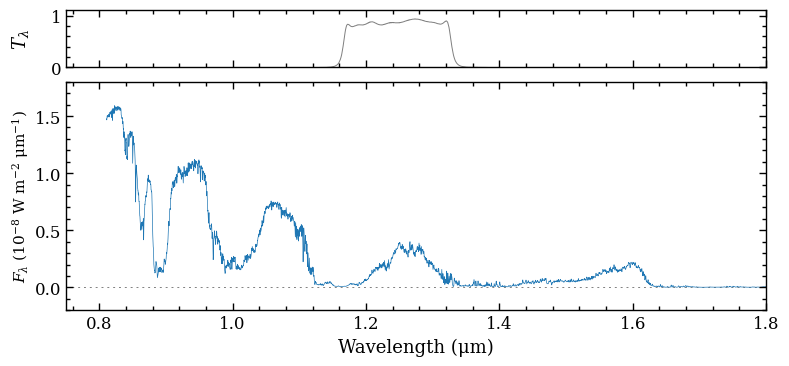

In [6]:
fig = plot_spectrum(boxes=[spec_box, ],
                    filters=['MKO/NSFCam.J'],
                    xlim=(0.75, 1.8),
                    ylim=(-2e-9, 1.8e-8),
                    offset=(-0.12, -0.05),
                    figsize=(7., 3.),
                    output=None)

The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

In [7]:
fig.axes

[<Axes: xlabel='Wavelength (μm)', ylabel='$F_\\lambda$ (10$^{-8}$ W m$^{-2}$ μm$^{-1}$)'>,
 <Axes: ylabel='$T_\\lambda$'>]

## Synthetic flux and magnitude

Next, we use the [SyntheticPhotometry](https://species.readthedocs.io/en/latest/species.phot.html#species.phot.syn_phot.SyntheticPhotometry) class to calculate the flux and magnitude for the [MKO/NSFCam.J](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=MKO/NSFCam.J&&mode=browse&gname=MKO&gname2=NSFCam#filter) filter. We first create an instance of [SyntheticPhotometry](https://species.readthedocs.io/en/latest/species.phot.html#species.phot.syn_phot.SyntheticPhotometry) with the filter name from the SVO website.

In [6]:
synphot = SyntheticPhotometry('MKO/NSFCam.J')

100%|████████████████████████████████████████| 288k/288k [00:00<00:00, 242MB/s]


Adding spectrum: Vega
Reference: Bohlin et al. 2014, PASP, 126
URL: https://ui.adsabs.harvard.edu/abs/2014PASP..126..711B/abstract


The average $J$-band flux is calculated with the [spectrum_to_flux](https://species.readthedocs.io/en/latest/species.phot.html#species.phot.syn_phot.SyntheticPhotometry.spectrum_to_flux) method. The error on the synthetic flux is estimated with Monte Carlo sampling of the input spectrum.

In [7]:
j_flux = synphot.spectrum_to_flux(wavelength, flux, error=error)
print(f'Flux (W m-2 um-1) = {j_flux[0]:.2e} +/- {j_flux[1]:.2e}')

Flux (W m-2 um-1) = 1.80e-09 +/- 8.03e-14


Similarly, we calculate the synthetic magnitude with the [spectrum_to_magnitude](https://species.readthedocs.io/en/latest/species.phot.html#species.phot.syn_phot.SyntheticPhotometry.spectrum_to_magnitude) method. Also the absolute magnitude can be calculated by providing the distance and uncertainty (set to `None` in the example). In [species](https://species.readthedocs.io/en/latest/species.html), the magnitude is defined relative to Vega, which is set in the [configuration file](https://species.readthedocs.io/en/latest/configuration.html) by default to a magnitude of 0.03 in all filters. For the selected $J$-band filter, Jupiter has a magnitude of 0.59 so the planet is comparable in brightness to Vega.

In [8]:
j_mag, _ = synphot.spectrum_to_magnitude(wavelength, flux, error=error, distance=None)
print(f'Apparent magnitude = {j_mag[0]:.2f} +/- {j_mag[1]:.2e}')

Apparent magnitude = 0.58 +/- 5.19e-05
